In [371]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import product
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Normalizer
from sklearn.svm import SVR

In [372]:
trainsets = pd.read_csv("/home/luming/kaggle/house-prices-advanced-regression-techniques/data/train.csv")
testsets = pd.read_csv("/home/luming/kaggle/house-prices-advanced-regression-techniques/data/test.csv")

In [373]:
#deal with the all dataset 
x_train=trainsets.iloc[:, :80].set_index('Id')
y_train=trainsets.iloc[:,-1]
x_test=testsets.iloc[:, :80].set_index('Id')

In [374]:
#import the variable sheet
vars_info=pd.read_csv("/home/luming/kaggle/house-prices-advanced-regression-techniques/data/variable_info.csv", index_col=0)
vars_info=vars_info.T
vars_info.head()
#because the SalePrice is Y, I drop the SalePrice.
vars_info=vars_info.drop(columns=[80], axis=1)
vars_info= vars_info.dropna(axis = 1)
vars_info=vars_info.T
vars_info.head()

,Id,correlate,continuous,Chinese_notes
1,MSSubClass,0,0,房子的類型（適合怎樣的家庭組成）
2,MSZoning,0,0,土地利用情形
3,LotFrontage,0,1,連接幾吋街道
4,LotArea,0,1,有幾平方英尺
5,Street,0,0,鄰近街道的鋪面


In [375]:
#groups the data for corrleate or continuous
groups = {}
i = [0,1]
j = [0,1]
for x in i:
    tmp = vars_info[(vars_info.continuous == x).to_numpy()]['Id'].to_numpy()
    groups[f'group_{x}'] = tmp

In [415]:
with open('data/data_description.txt','r') as f:
    a=f.readlines()

In [416]:
# generate the location of each variable in data_description.txt
info = {}
for i in range(len(a)):
    name = a[i].split(':')[0]
    if name in x_train.columns:
        info[name] = i

In [417]:
# make start & end location of each variable
info_df = pd.Series(info).to_frame()
info_df = pd.concat([info_df, info_df.shift(-1)-1],axis=1)
info_df = info_df.fillna(523).astype(int)
info_df

,0,0
MSSubClass,0,18
MSZoning,19,29
LotFrontage,30,31
LotArea,32,33
Street,34,38
...,...,...
MiscVal,496,497
MoSold,498,499
YrSold,500,501
SaleType,502,514


In [418]:
# get the categories of each variable
categories = {}
for idx, name in enumerate(info_df.index):
    if name in groups['group_0']:
        categories[name] = [x.split('\t')[0].strip() for x in a[info_df.iloc[idx, 0]+2: info_df.iloc[idx, 1]]]

In [419]:
#check domain of variables
[k for k in categories.keys() if k not in cat.columns]
[k for k in cat.columns if k not in categories.keys()]

[]

In [420]:
#check domain of categories
store = {}
for k,v in categories.items():
    store[k] = []
    for i in cat[k].values:
        if i not in v and i not in store[k]:
            store[k].append(i)
# 人工校正
#store
#pd.unique(cat['Exterior2nd'])
#categories['SaleType']

In [425]:
encoder = OneHotEncoder(
    categories = [categories[k] for k in cat.columns],
    handle_unknown = 'ignore'
)

In [434]:
# train dataset
# make all data to str
cat = x_train.loc[:,groups["group_0"]].astype(str)
print(cat.shape)
x_train_cat = encoder.fit_transform(cat.values).toarray()
print(x_train_cat.shape)
imputer = SimpleImputer()
x_train_con = imputer.fit_transform(x_train.loc[:,groups["group_1"]].values)
train_data = np.concatenate([x_train_cat, x_train_con], axis=1)

(1460, 46)
(1460, 320)


In [435]:
# test dataset
cat = x_test.loc[:,groups["group_0"]].astype(str)
print(cat.shape)
x_test_cat = encoder.transform(cat.values).toarray()
print(x_test_cat.shape)
imputer = SimpleImputer()
x_test_con = imputer.fit_transform(x_test.loc[:,groups["group_1"]].values)
test_data = np.concatenate([x_test_cat, x_test_con], axis=1)

(1459, 46)
(1459, 320)


In [436]:
normalizer = Normalizer()
train_normdata = normalizer.fit_transform(train_data)
test_normdata = normalizer.transform(test_data)

In [462]:
train_label = y_train.to_numpy()
clf = SVR(C=1, epsilon=0.02)
clf.fit(train_normdata, train_label)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.02, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [463]:
train_pred = clf.predict(train_normdata)

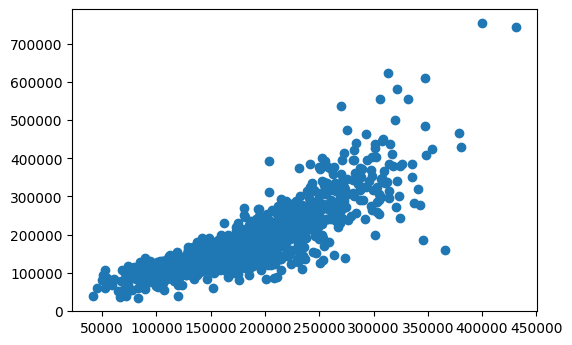

In [471]:
fig, ax = plt.subplots(1,1,dpi=100)
ax.plot(train_pred.astype(int), train_label, 'o')

In [466]:
class Norm:
    def __init__(self, data):
        self.data = data
        self.max = max(data)
        self.min = min(data)

    def normalize(self, data):
        return (data-self.min)/(self.max-self.min)

    def restore(self, normdata):
        return normdata * (self.max-self.min) + self.min
        

In [467]:
norm = Norm(train_label)
train_normlabel = norm.normalize(train_label)

In [468]:
clf.fit(train_normdata, train_normlabel)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.02, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [470]:
train_pred = norm.restore(clf.predict(train_normdata))